# Pre Start (Imports and Funcs)

## Імпорт

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
plt.close("all")
# from IPython.display import IFrame

# %matplotlib widget


## Допоміжні функції

In [2]:
def latex_matrix(matrix):
    matrix_ = matrix.copy()
    text = "$\n"
    text += r"\left(\begin{matrix}" + "\n"
    for row in matrix_:
        text += " "*4 + " & ".join(map(str, row)) + r" \\" + "\n"
    text += r"\end{matrix}\right)"
    text += "\n$"
    return text

## Основні функції

In [3]:
L = 1

def u0(x):
    return x * (x + 1)

def u2(t):
    return u0(L) * np.cos(np.pi * t)

def u(t, x):
    return u0(x) * np.cos(np.pi * t)

def F(t, x):
    return -np.cos(np.pi * t) * (np.pi**2 * x * (x + 1) + 2)

## Задання точок

In [4]:
x_limits = [0, L]
t_limits = [0, 2]
u1 = 0

# Main Part

$$ u(t,0) = 0 \cdot 1 \cdot \cos(\pi \cdot t) = 0 $$
$$ u(t, L) = L \cdot (L+1) \cdot \cos(\pi \cdot t) = 1 \cdot 2 \cdot \cos(\pi \cdot t) = 2 \cdot \cos(\pi \cdot t) $$

$$ \frac{\partial{u}}{\partial{t}}(t = 0) = 0 $$
$$ \frac{u_i^{k+1} - u_i^{k}}{\Delta{t}} = 0 $$
$$ u_i^{k+1} = u_i^{k}$$

## Тришарова схема з вагами

\begin{align*}
    u(k+1, i) & - \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \cdot \left(u(k+1, i+1) - 2 \cdot u(k+1, i) + u(k+1, i-1)\right) = \\
    & = 2 \cdot u(k, i) - u(k-1, i)  + \\
    & + \Delta{t}^2 \cdot \sigma_1 \cdot F(k+1, i) + \\
    & + \Delta{t}^2 \cdot \left(1 - \sigma_1 - \sigma_2 \right) \cdot \left(\frac{u(k, i+1) - 2 \cdot u(k, i) + u(k, i-1)}{\Delta{x}^2} + F(k, i)\right) + \\
    & + \Delta{t}^2 \cdot \sigma_2 \cdot \left(\frac{u(k-1, i+1) - 2 \cdot u(k-1, i) + u(k-1, i-1)}{\Delta{x}^2} + F(k-1, i)\right)
\end{align*}

### Дозадання точок

In [5]:
nx = 100
nt = 100_000
# nt = 100

sigma_1 = 0.25
sigma_2 = 0.25

x = np.linspace(*x_limits, nx)
t = np.linspace(*t_limits, nt)

dx = x[1] - x[0]
dt = t[1] - t[0]

assert sigma_1 >= sigma_2, f"Відсутня коректна робота! {sigma_1} < {sigma_2}"
if sigma_1 + sigma_2 < 0.5:
    assert dt <= dx/np.sqrt(1 - 2 * (sigma_1 + sigma_2)), f"Відсутня стійкість! {dt} <= {dx/np.sqrt(1 - 2 * (sigma_1 + sigma_2))}"


In [6]:
U = np.zeros((nt, nx), dtype=float)
# U[:, 0] = u1
# U[:, -1] = u2(t)
# U[0, :] = u0(x)
# U[1, 1:-1] = U[0, 1:-1]
U[0, :] = u0(x)
U[1, 1:-1] = (
    U[0, 1:-1]
    + dt**2 / 2 * (F(t[0], x[1:-1]) + (U[0, 2:] - 2 * U[0, 1:-1] + U[0, :-2]) / dx**2)
)
U[1, 0] = u1
U[1, -1] = u2(t[1])

### Побудова

$$ u(k+1, i) - \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \cdot \left(u(k+1, i+1) - 2 \cdot u(k+1, i) + u(k+1, i-1 \right) $$

$$ u(k+1, i) + 2 \cdot \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \cdot u(k+1, i) - \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \cdot u(k+1, i+1) - \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \cdot u(k+1, i-1) $$

$$ \left( 1 + 2 \cdot \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \right) \cdot u(k+1, i) - \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \cdot u(k+1, i+1) - \frac{\Delta{t}^2 \cdot \sigma_1}{\Delta{x}^2} \cdot u(k+1, i-1) $$

In [7]:
from numba import jit    

@jit
def TDMA(a,b,c,d):
    n = len(d)
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)
    
    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

coef = (dt**2 * sigma_1) / dx**2

for tn in tqdm(range(1, nt - 1)):
    left_part = 2 * U[tn, 1:-1] - U[tn - 1, 1:-1]
    right_part_future = dt**2 * sigma_1 * F(t[tn + 1], x[1:-1])
    right_part_current = dt**2 * (1 - sigma_1 - sigma_2) * ((U[tn, 2:] - 2 * U[tn, 1:-1] + U[tn, :-2]) / dx**2 + F(t[tn], x[1:-1]))
    right_part_past = dt**2 * sigma_2 * ((U[tn - 1, 2:] - 2 * U[tn - 1, 1:-1] + U[tn - 1, :-2]) / dx**2 + F(t[tn - 1], x[1:-1]))
    B = left_part + right_part_future + right_part_current + right_part_past

    curr = 1 + 2 * coef
    past, future = -coef, -coef
    U[tn + 1, 1:-1] = TDMA(np.ones(nx - 3) * past, np.ones(nx - 2) * curr, np.ones(nx - 3) * future, B)
    U[tn + 1, 0] = u1
    U[tn + 1, -1] = u2(t[tn + 1])

    # A = np.zeros((nx - 2, nx - 2))
    # A[0, 0] = 1 + 2 * coef
    # A[0, 1] = -coef
    # for i in range(1, nx - 3):
    #     A[i, i] = 1 + 2 * coef
    #     A[i, i + 1] = -coef
    #     A[i, i - 1] = -coef
    # A[-1, -1] = 1 + 2 * coef
    # A[-1, -2] = -coef

    # break
    # U[tn + 1, 1:-1] = np.linalg.solve(A, B)

    # n = nx - 2
    # a = -r1 * np.ones(n - 1)
    # b = (1 + 2 * r1) * np.ones(n)
    # c = -r1 * np.ones(n - 1)
    # d = RHS.copy()

    # for i in range(1, n):
    #     w = a[i - 1] / b[i - 1]
    #     b[i] -= w * c[i - 1]
    #     d[i] -= w * d[i - 1]

    # sol = np.zeros(n)
    # sol[-1] = d[-1] / b[-1]
    # for i in range(n - 2, -1, -1):
    #     sol[i] = (d[i] - c[i] * sol[i + 1]) / b[i]

    # U[tn + 1, 1:-1] = sol
# for a in A:
#     pprint(a)
    

100%|██████████| 99998/99998 [00:09<00:00, 10149.57it/s]


In [8]:
# U

In [9]:
# for tn in tqdm(range(1, nt-1)):
#     right_part = 2 * U[tn, 1:-1] - U[tn - 1, 1:-1] + \
#                 dt**2 * sigma_1 * F(t[tn + 1], x[1:-1]) + \
#                 dt**2 * (1 - sigma_1 - sigma_2) * ((U[tn, 2:] - 2 * U[tn, 1:-1] + U[tn, :-2]) / dx**2 + F(t[tn], x[1:-1])) + \
#                 dt**2 * sigma_2 * ((U[tn - 1, 2:] - 2 * U[tn - 1, 1:-1] + U[tn - 1, :-2]) / dx**2 + F(t[tn - 1], x[1:-1]))
    
#     left_part = 0
#     coefs = np.linalg.inv(left_part) @ right_part
    
#     # for xn in range(1, nx-1):
#     #     right_part = 2 * U[tn, xn] - U[tn - 1, xn] + \
#     #                 dt**2 * sigma_1 * F(t[tn + 1], x[xn]) + \
#     #                 dt**2 * (1 - sigma_1 - sigma_2) * ((U[tn, xn + 1] - 2 * U[tn, xn] + U[tn, xn - 1])/dx**2 + F(t[tn], x[xn])) + \
#     #                 dt**2 * sigma_2 * ((U[tn - 1, xn + 1] - 2 * U[tn - 1, xn] + U[tn - 1, xn - 1])/dx**2 + F(t[tn - 1], x[xn]))
#     # print(right_part.shape)

In [10]:
# raise NotImplementedError

In [11]:
# for tn in tqdm(range(1, nt-1)):
#     F_ = F(t[tn], x[1:-1])
#     right_part = (U[tn, 2:] - 2 * U[tn, 1:-1] + U[tn, :-2]) / dx**2 + F_
#     left_part = 2 * U[tn, 1:-1] - U[tn - 1, 1:-1]
#     U[tn + 1, 1:-1] = left_part + dt**2 * right_part
    
    

In [12]:
print(latex_matrix(U[:10, :3]))
print(latex_matrix(U[:10, U.shape[1]-2:]))
print(latex_matrix(U[U.shape[0]-3:, :3]))
print(latex_matrix(U[U.shape[0]-3:, U.shape[1]-2:]))

$
\left(\begin{matrix}
    0.0 & 0.01020304050607081 & 0.020610141822263034 \\
    0.0 & 0.010203040485930412 & 0.02061014178157943 \\
    0.0 & 0.01020304042550922 & 0.020610141659528625 \\
    0.0 & 0.010203040324807233 & 0.020610141456110617 \\
    0.0 & 0.010203040183824454 & 0.020610141171325407 \\
    0.0 & 0.010203040002560882 & 0.020610140805172993 \\
    0.0 & 0.010203039781016518 & 0.020610140357653375 \\
    0.0 & 0.01020303951919136 & 0.020610139828766555 \\
    0.0 & 0.010203039217085414 & 0.020610139218512537 \\
    0.0 & 0.01020303887469868 & 0.020610138526891322 \\
\end{matrix}\right)
$
$
\left(\begin{matrix}
    1.9697990001020307 & 2.0 \\
    1.9697989962137255 & 1.9999999960520793 \\
    1.969797024313463 & 1.9999999842083171 \\
    1.9697930844166331 & 1.9999999644687136 \\
    1.969787176554003 & 1.9999999368332688 \\
    1.9697793007717173 & 1.999999901301983 \\
    1.9697694571312974 & 1.999999857874856 \\
    1.969757645709641 & 1.9999998065518878 \\
    1.96974

### Графік

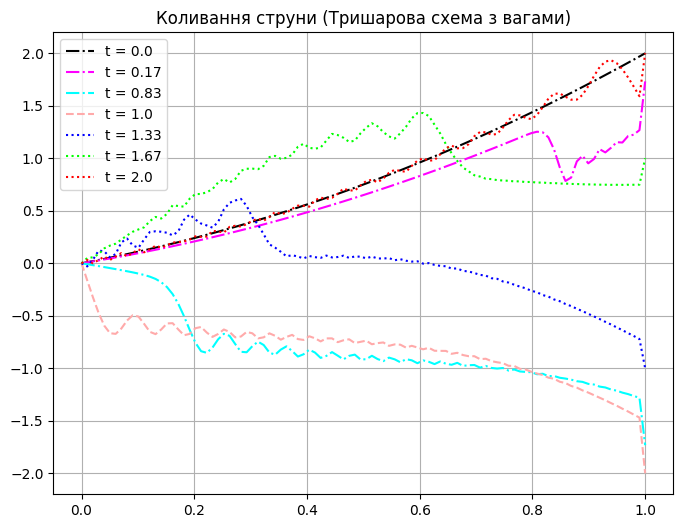

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

start = 0
middle_start = int(0.5 * nt // 6)
middle1 = int(2.5 * nt // 6)
middle2 = 3 * nt // 6
middle3 = 4 * nt // 6
middle_end = 5 * nt // 6
end = nt - 1

indexes_for_error = [start, middle_start, middle1, middle2, middle3, middle_end, end]

ax.plot(x, U[start], "#000000", linestyle="-.", label=f"t = {np.round(t[start], 2)}")[0]
ax.plot(x, U[middle_start], "#FF00FF", linestyle="-.", label=f"t = {np.round(t[middle_start], 2)}")[0]
ax.plot(x, U[middle1], "#00FFFF", linestyle="-.", label=f"t = {np.round(t[middle1], 2)}")[0]
ax.plot(x, U[middle2], "#FFAAAA", linestyle="--", label=f"t = {np.round(t[middle2], 2)}")[0]
ax.plot(x, U[middle3], "#0000FF", linestyle=":", label=f"t = {np.round(t[middle3], 2)}")[0]
ax.plot(x, U[middle_end], "#00FF00", linestyle=":", label=f"t = {np.round(t[middle_end], 2)}")[0]
ax.plot(x, U[end], "#FF0000", linestyle=":", label=f"t = {np.round(t[end], 2)}")[0]

ax.set_title("Коливання струни (Тришарова схема з вагами)")
ax.grid(True)
ax.legend()
plt.savefig("./Images/Main_key_time.png")
plt.show()

### Похибка

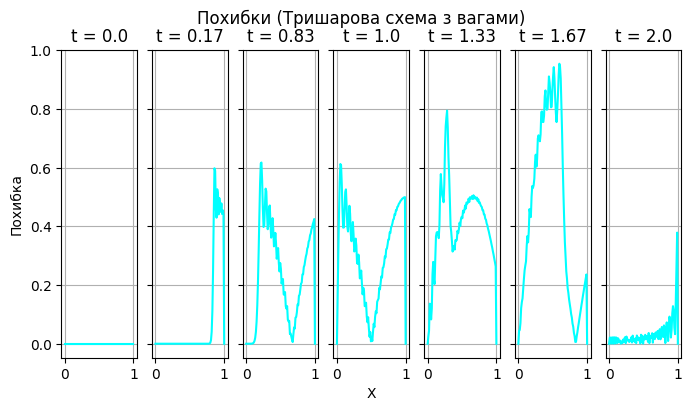

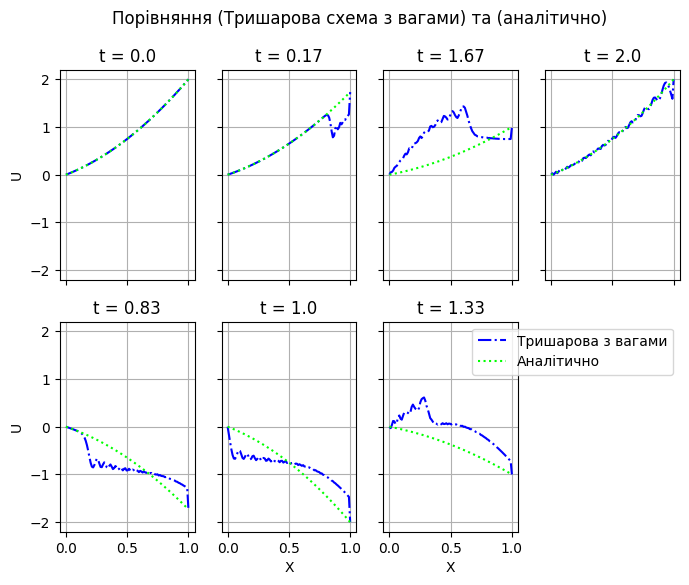

In [14]:
fig, axes = plt.subplots(1, len(indexes_for_error), figsize=(8, 4), sharex=True, sharey=True)
axes = axes.flatten()
plt.suptitle("Похибки (Тришарова схема з вагами)")
for index_index in range(len(indexes_for_error)):
    ax = axes[index_index]

    index = indexes_for_error[index_index]
    U_ = u(t[index], x)
    error = np.abs(U[index] - U_)
    
    ax.plot(x, error, "#00FFFF")[0]
    ax.set_title(f"t = {np.round(t[index], 2)}")
    ax.grid(True)
axes[0].set_ylabel("Похибка")
axes[3].set_xlabel("X")
plt.savefig("./Images/Main_error.png")
plt.show()

converter = {
    0: 0,
    1: 1,
    2: 4,
    3: 5,
    4: 6,
    5: 2,
    6: 3
}

fig, axes = plt.subplots(2, int(round(len(indexes_for_error)/2)), figsize=(8, 6), sharex=True, sharey=True)
axes = axes.flatten()
plt.suptitle("Порівняння (Тришарова схема з вагами) та (аналітично)")
for index_index in range(len(indexes_for_error)):
    ax = axes[converter[index_index]]

    index = indexes_for_error[index_index]
    U_ = u(t[index], x)
    error = np.abs(U[index] - U_)
    
    line1, = ax.plot(x, U[index], "#0000FF", linestyle="-.", label="Тришарова схема з вагами")
    line2, = ax.plot(x, U_, "#00FF00", linestyle=":", label="Аналітичний")
    ax.set_title(f"t = {np.round(t[index], 2)}")
    ax.grid(True)
plt.legend([line1, line2], ['Тришарова з вагами', "Аналітично"])
axes[-1].set_axis_off()
axes[0].set_ylabel("U")
axes[4].set_ylabel("U")
axes[5].set_xlabel("X")
axes[6].set_xlabel("X")
plt.savefig("./Images/Main_compare.png")
plt.show()

### Анімація

MovieWriter ffmpeg unavailable; using Pillow instead.


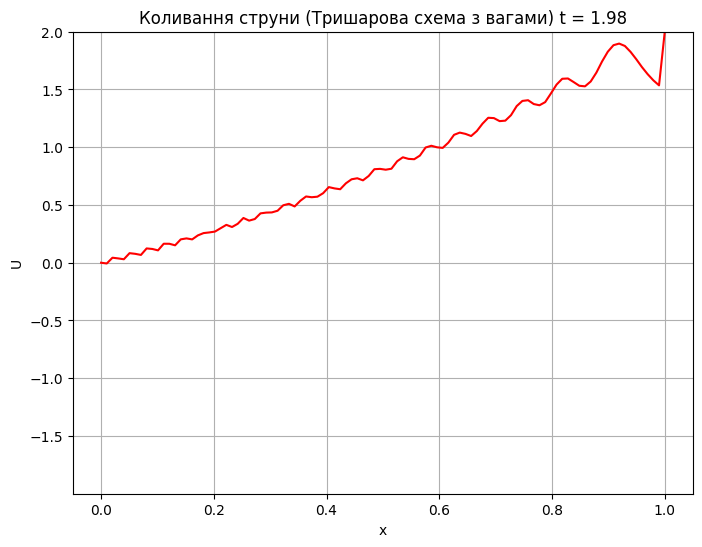

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
line = ax.plot(x, U[0], "r")[0]

ax.set_title("Коливання струни (Тришарова схема з вагами) t = 0")
ax.set_ylim(U.min(), U.max())
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.grid(True)
every = 1000
# every = 100
# every = 10
# every = 1

def update(frame):
    ax.set_title(f"Коливання струни (Тришарова схема з вагами) t = {np.round(t[frame * every], 2)}")
    line.set_xdata(x)
    line.set_ydata(U[frame * every])
    return line

anim = animation.FuncAnimation(fig, func=update, frames=U.shape[0]//every, interval=100)
file_name = "./Images/Main_time_string.gif"
anim.save(file_name, fps=20)
plt.show()

![Gif](./Images\Main_time_string.gif)

### 2Д

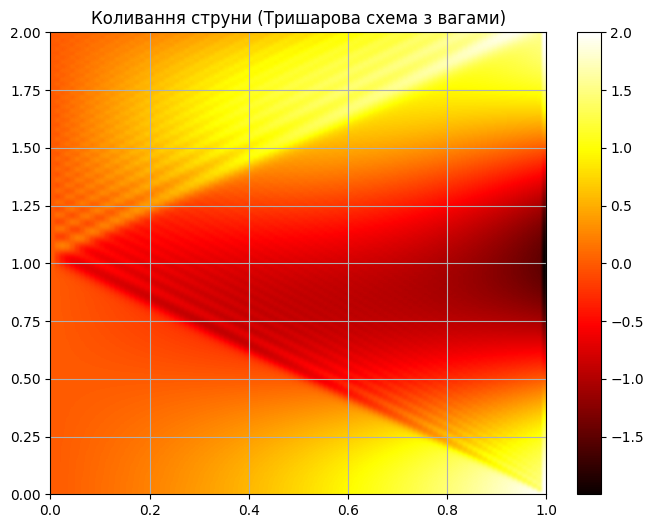

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
colorbar = ax.imshow(U, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(colorbar, ax=ax)

ax.set_title("Коливання струни (Тришарова схема з вагами)")
ax.grid(True)
plt.savefig("./Images/Main_2D.png")
plt.show()

### 3Д

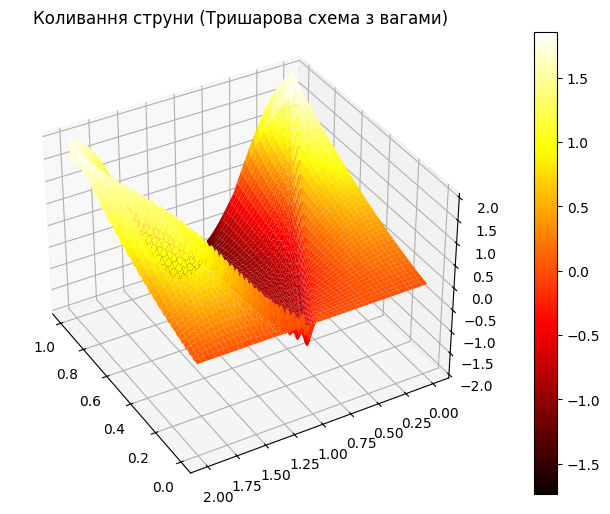

In [17]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
x_plot, t_plot = np.meshgrid(x, t)
colorbar1 = ax1.plot_surface(x_plot, t_plot, U, cmap="hot")
fig.colorbar(colorbar1, ax=ax1, fraction=0.05, pad=0.1)

ax1.view_init(elev=35, azim=60 + 90)

ax1.set_title("Коливання струни (Тришарова схема з вагами)")
ax1.grid(True)
plt.savefig("./Images/Main_3D.png")
plt.show()

In [18]:
raise NotImplementedError

NotImplementedError: 

## Явна схема

$$ u(k+1, i) = 2 \cdot u(k, i) - u(k-1, i) + \Delta{t}^2 \cdot \left( \frac{u(k, i+1) - 2 \cdot u(k, i) + u(k, i-1)}{\Delta{x}^2} + F(k, i) \right) $$


### Дозадання точок

In [ ]:
nx = 100
nt = 1_00_000


x = np.linspace(*x_limits, nx)
t = np.linspace(*t_limits, nt)

dx = x[1] - x[0]
dt = t[1] - t[0]

diff = dt/ dx**2
print("dt/dx**2 = ", diff)
assert diff <= .5, f"Нестійкість! {diff}"

dt/dx**2 =  0.19602196021960216


In [ ]:
U = np.zeros((nt, nx), dtype=float)
U[:, 0] = u1
U[:, -1] = u2(t)
U[0, :] = u0(x)

### Побудова

In [ ]:
U[1, 1:-1] = U[0, 1:-1]

for tn in tqdm(range(1, nt-1)):
    F_ = F(t[tn], x[1:-1])
    right_part = (U[tn, 2:] - 2 * U[tn, 1:-1] + U[tn, :-2]) / dx**2 + F_
    left_part = 2 * U[tn, 1:-1] - U[tn - 1, 1:-1]
    U[tn + 1, 1:-1] = left_part + dt**2 * right_part
    
    

100%|██████████| 99998/99998 [00:02<00:00, 37058.79it/s]


In [ ]:
print(latex_matrix(U[:10, :3]))
print(latex_matrix(U[:10, 98:]))
print(latex_matrix(U[99_997:, :3]))
print(latex_matrix(U[99_997:, 98:]))

$
\left(\begin{matrix}
    0.0 & 0.01020304050607081 & 0.020610141822263034 \\
    0.0 & 0.01020304050607081 & 0.020610141822263034 \\
    0.0 & 0.010203040465790018 & 0.02061014174089583 \\
    0.0 & 0.010203040385228434 & 0.020610141578161423 \\
    0.0 & 0.010203040264386062 & 0.020610141334059816 \\
    0.0 & 0.010203040103262902 & 0.020610141008591012 \\
    0.0 & 0.010203039901858956 & 0.020610140601755013 \\
    0.0 & 0.010203039660174228 & 0.020610140113551823 \\
    0.0 & 0.01020303937820872 & 0.020610139543981446 \\
    0.0 & 0.010203039055962435 & 0.020610138893043885 \\
\end{matrix}\right)
$
$
\left(\begin{matrix}
    1.9697990001020307 & 2.0 \\
    1.9697990001020307 & 1.9999999960520793 \\
    1.969798992325405 & 1.9999999842083171 \\
    1.969798976772138 & 1.9999999644687136 \\
    1.9697989534422145 & 1.9999999368332688 \\
    1.969798922335619 & 1.999999901301983 \\
    1.9697988834523361 & 1.999999857874856 \\
    1.9697988367923507 & 1.9999998065518878 \\
    1.9697

### Графік

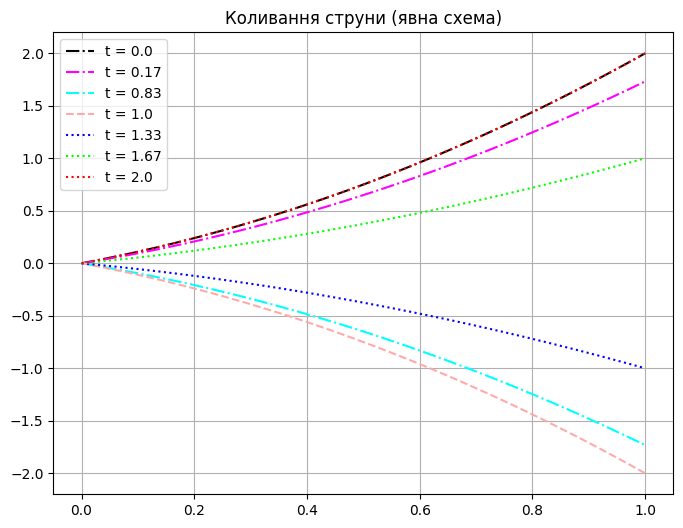

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

start = 0
middle_start = int(0.5 * nt // 6)
middle1 = int(2.5 * nt // 6)
middle2 = 3 * nt // 6
middle3 = 4 * nt // 6
middle_end = 5 * nt // 6
end = nt - 1

indexes_for_error = [start, middle_start, middle1, middle2, middle3, middle_end, end]

ax.plot(x, U[start], "#000000", linestyle="-.", label=f"t = {np.round(t[start], 2)}")[0]
ax.plot(x, U[middle_start], "#FF00FF", linestyle="-.", label=f"t = {np.round(t[middle_start], 2)}")[0]
ax.plot(x, U[middle1], "#00FFFF", linestyle="-.", label=f"t = {np.round(t[middle1], 2)}")[0]
ax.plot(x, U[middle2], "#FFAAAA", linestyle="--", label=f"t = {np.round(t[middle2], 2)}")[0]
ax.plot(x, U[middle3], "#0000FF", linestyle=":", label=f"t = {np.round(t[middle3], 2)}")[0]
ax.plot(x, U[middle_end], "#00FF00", linestyle=":", label=f"t = {np.round(t[middle_end], 2)}")[0]
ax.plot(x, U[end], "#FF0000", linestyle=":", label=f"t = {np.round(t[end], 2)}")[0]

ax.set_title("Коливання струни (явна схема)")
ax.grid(True)
ax.legend()
plt.savefig("./Images/Straight_key_time.png")
plt.show()

### Похибка

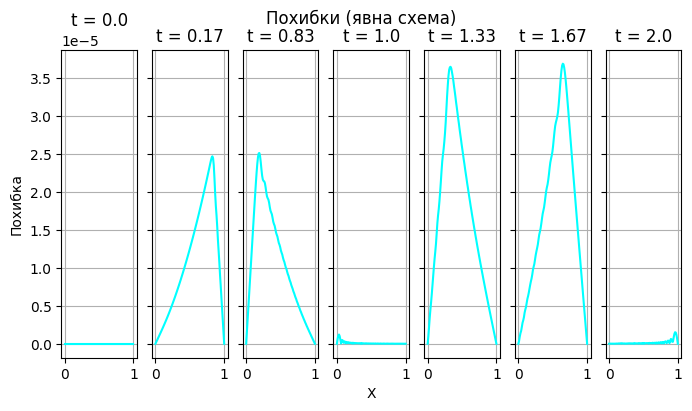

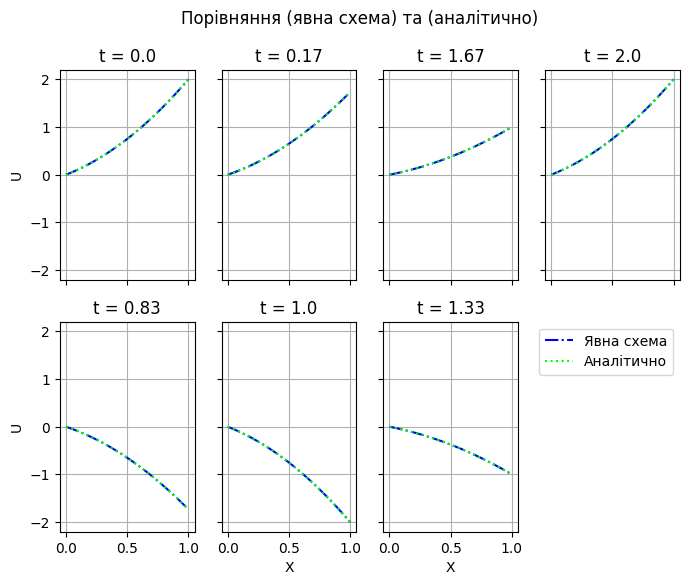

In [ ]:
fig, axes = plt.subplots(1, len(indexes_for_error), figsize=(8, 4), sharex=True, sharey=True)
axes = axes.flatten()
plt.suptitle("Похибки (явна схема)")
for index_index in range(len(indexes_for_error)):
    ax = axes[index_index]

    index = indexes_for_error[index_index]
    U_ = u(t[index], x)
    error = np.abs(U[index] - U_)
    
    ax.plot(x, error, "#00FFFF")[0]
    ax.set_title(f"t = {np.round(t[index], 2)}")
    ax.grid(True)
axes[0].set_ylabel("Похибка")
axes[3].set_xlabel("X")
plt.savefig("./Images/Straight_error.png")
plt.show()

converter = {
    0: 0,
    1: 1,
    2: 4,
    3: 5,
    4: 6,
    5: 2,
    6: 3
}

fig, axes = plt.subplots(2, int(round(len(indexes_for_error)/2)), figsize=(8, 6), sharex=True, sharey=True)
axes = axes.flatten()
plt.suptitle("Порівняння (явна схема) та (аналітично)")
for index_index in range(len(indexes_for_error)):
    ax = axes[converter[index_index]]

    index = indexes_for_error[index_index]
    U_ = u(t[index], x)
    error = np.abs(U[index] - U_)
    
    line1, = ax.plot(x, U[index], "#0000FF", linestyle="-.", label="Явна схема")
    line2, = ax.plot(x, U_, "#00FF00", linestyle=":", label="Аналітичний")
    ax.set_title(f"t = {np.round(t[index], 2)}")
    ax.grid(True)
plt.legend([line1, line2], ['Явна схема', "Аналітично"])
axes[-1].set_axis_off()
axes[0].set_ylabel("U")
axes[4].set_ylabel("U")
axes[5].set_xlabel("X")
axes[6].set_xlabel("X")
plt.savefig("./Images/Straight_compare.png")
plt.show()

### Анімація

MovieWriter ffmpeg unavailable; using Pillow instead.


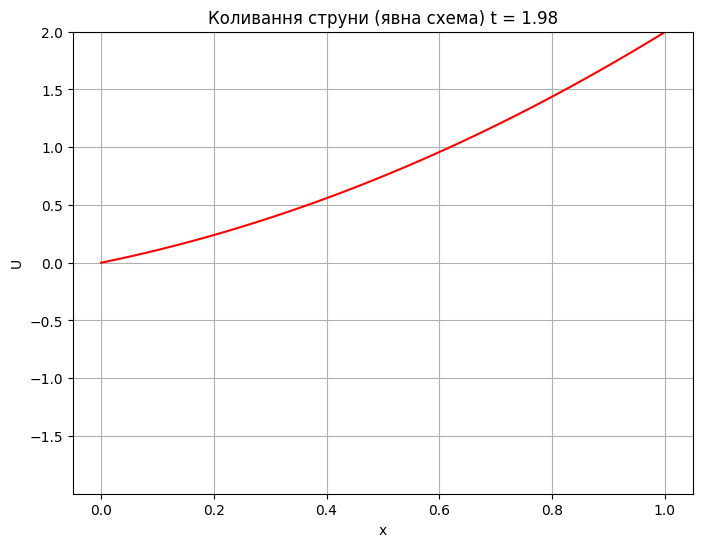

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
line = ax.plot(x, U[0], "r")[0]

ax.set_title("Коливання струни (явна схема) t = 0")
ax.set_ylim(U.min(), U.max())
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.grid(True)
every = 1000

def update(frame):
    ax.set_title(f"Коливання струни (явна схема) t = {np.round(t[frame * every], 2)}")
    line.set_xdata(x)
    line.set_ydata(U[frame * every])
    return line

anim = animation.FuncAnimation(fig, func=update, frames=U.shape[0]//every, interval=100)
file_name = "./Images/Straight_time_string.gif"
anim.save(file_name, fps=20)
plt.show()

### 2Д

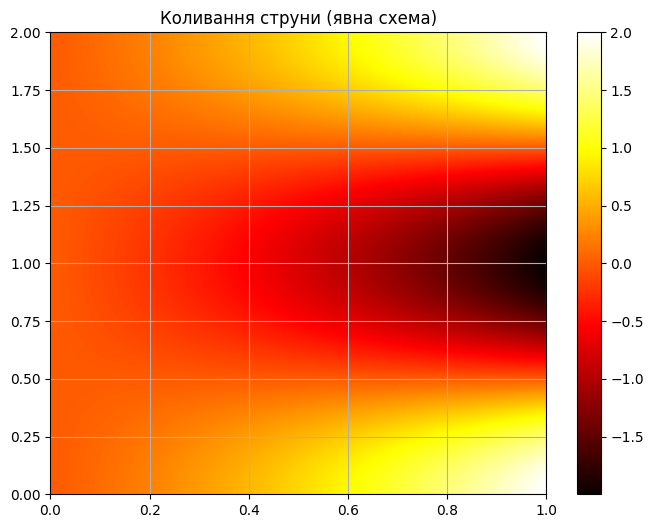

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
colorbar = ax.imshow(U, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(colorbar, ax=ax)

ax.set_title("Коливання струни (явна схема)")
ax.grid(True)
plt.savefig("./Images/Straight_2D.png")
plt.show()

### 3Д

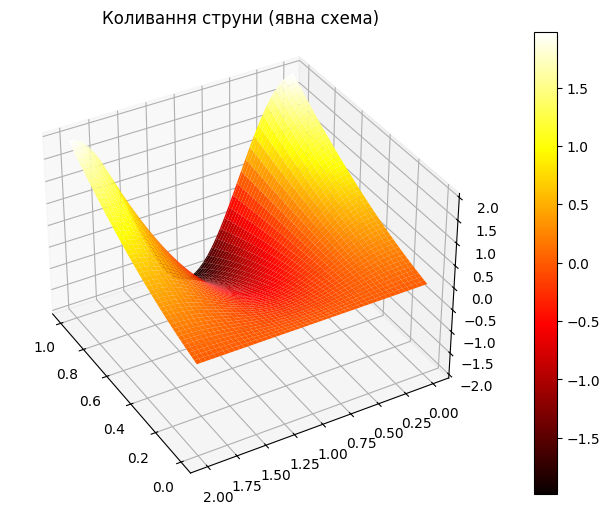

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
x_plot, t_plot = np.meshgrid(x, t)
colorbar1 = ax1.plot_surface(x_plot, t_plot, U, cmap="hot")
fig.colorbar(colorbar1, ax=ax1, fraction=0.05, pad=0.1)

ax1.view_init(elev=35, azim=60 + 90)

ax1.set_title("Коливання струни (явна схема)")
ax1.grid(True)
plt.savefig("./Images/Straight_3D.png")
plt.show()